### **DEPRESSION DETECTION FROM REDDIT DATA USING RANDOM, ANN, KNN AND LSTM**

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 114 kB 4.3 MB/s 


In [4]:
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

In [5]:
from keras_preprocessing.sequence import pad_sequences

In [6]:
%%time

glove_embeddings = np.load('/content/drive/My Drive/TOBIJOSEPH/Tobi/glove.840B.300d.pkl', allow_pickle=True)

CPU times: user 8.7 s, sys: 5.31 s, total: 14 s
Wall time: 54.4 s


# DATA PREPROCESSING

In [7]:
data=pd.read_csv('/content/drive/MyDrive/TOBIJOSEPH/Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [8]:
data['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [9]:
data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

# SPLIT DATA FOR TRAINING & TESTING

In [10]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

In [11]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [12]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [13]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

100%|██████████| 46415/46415 [00:02<00:00, 16529.11it/s]


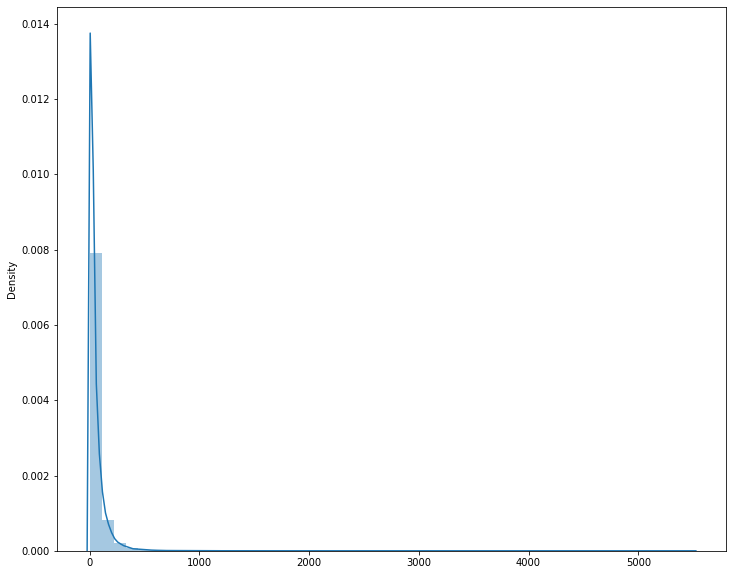

In [14]:
plt.figure(figsize=(12,10))
sns.distplot(train_text_length)
# plt.axis([-10,100,0,0.03])
plt.show()

In [15]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

In [16]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

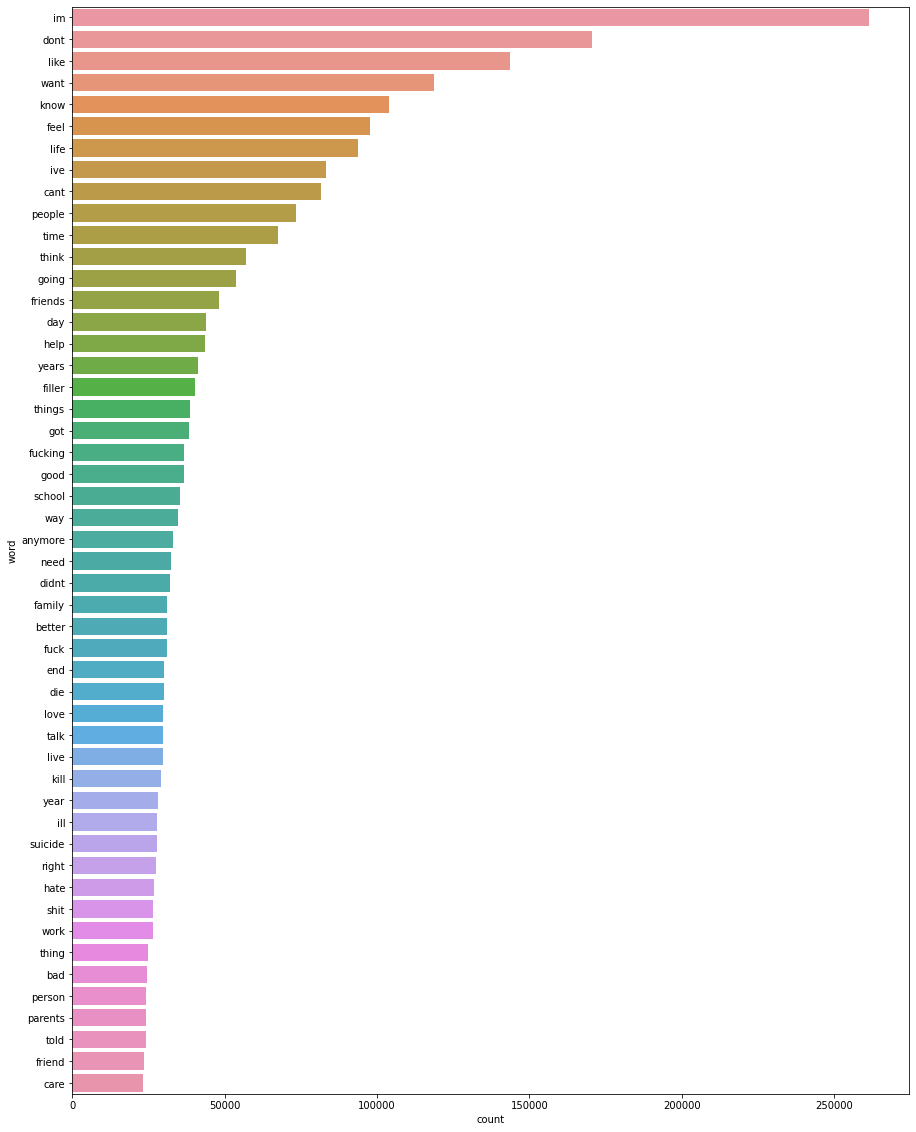

In [17]:
plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

In [18]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=40)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=40)

In [19]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [20]:
glove_embedding={}
with open('/content/drive/My Drive/TOBIJOSEPH/Tobi/glove.840B.300d.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [21]:
v=len(tokenizer.word_index)

embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [22]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

# RANDOM FOREST CLASSIFIER

In [23]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
rf.fit(train_text_pad,train_output)

prediction_test = rf.predict(test_text_pad)
print(metrics.accuracy_score(test_output, prediction_test))

0.7640202520736831


In [24]:
print (metrics.accuracy_score(test_output, prediction_test))

0.7640202520736831


# **KNN**

In [25]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(train_text_pad,train_output)
Y_pred_knn=knn.predict(test_text_pad)

In [26]:
print (metrics.accuracy_score(test_output, Y_pred_knn))

0.725433588279651


# LSTM

In [27]:
import tensorflow
model=Sequential()
model.add(Input(shape=(40,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=tensorflow.keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=5,batch_size=256,callbacks=[early_stop,reducelr])
pred_lstm = model.predict(test_text_pad)

Epoch 1/5
726/726 [==============================] - 59s 77ms/step - loss: 0.3509 - accuracy: 0.8525 - val_loss: 0.2606 - val_accuracy: 0.8951 - lr: 0.1000
Epoch 2/5
726/726 [==============================] - 59s 81ms/step - loss: 0.2525 - accuracy: 0.8987 - val_loss: 0.2532 - val_accuracy: 0.8982 - lr: 0.1000
Epoch 3/5
726/726 [==============================] - 57s 79ms/step - loss: 0.2348 - accuracy: 0.9069 - val_loss: 0.2236 - val_accuracy: 0.9117 - lr: 0.1000
Epoch 4/5
726/726 [==============================] - 57s 79ms/step - loss: 0.2240 - accuracy: 0.9118 - val_loss: 0.2199 - val_accuracy: 0.9136 - lr: 0.1000
Epoch 5/5
726/726 [==============================] - 58s 79ms/step - loss: 0.2144 - accuracy: 0.9158 - val_loss: 0.2130 - val_accuracy: 0.9162 - lr: 0.1000


In [30]:
predictions_test = (model.predict(test_text_pad) > 0.5).astype("int32")
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,predictions_test,
                            target_names=lbl_target.inverse_transform([0,1])))

TESTING DATA CLASSIFICATION REPORT 
 

              precision    recall  f1-score   support

 non-suicide       0.91      0.93      0.92     23209
     suicide       0.93      0.90      0.92     23206

    accuracy                           0.92     46415
   macro avg       0.92      0.92      0.92     46415
weighted avg       0.92      0.92      0.92     46415



Text(42.0, 0.5, 'Truth')

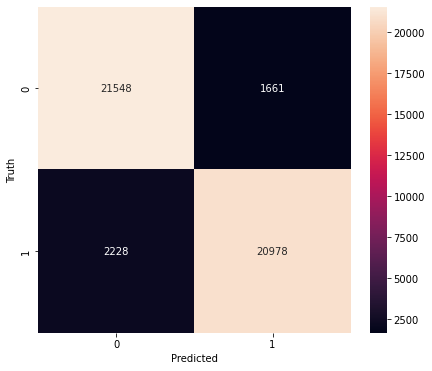

In [31]:
import seaborn as sns

cm = tf.math.confusion_matrix(labels=test_output, predictions=predictions_test)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

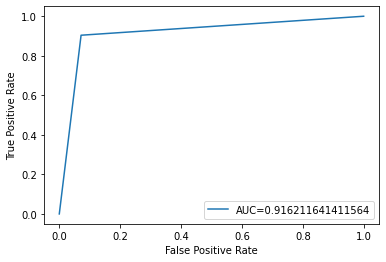

In [32]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(test_output,  predictions_test)
auc = metrics.roc_auc_score(test_output,  predictions_test)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# CLASSIFICATION REPORT RANDOM FOREST

In [33]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(test_output, prediction_test))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77     23209
           1       0.77      0.75      0.76     23206

    accuracy                           0.76     46415
   macro avg       0.76      0.76      0.76     46415
weighted avg       0.76      0.76      0.76     46415



Text(42.0, 0.5, 'Truth')

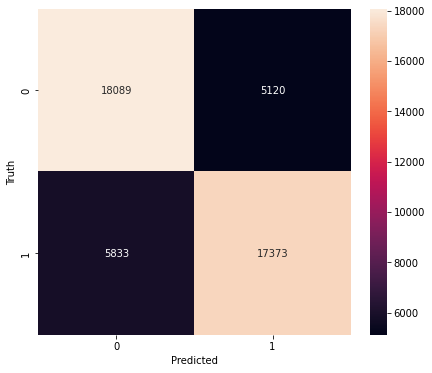

In [34]:
import seaborn as sns

cm = tf.math.confusion_matrix(labels=test_output, predictions=prediction_test)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

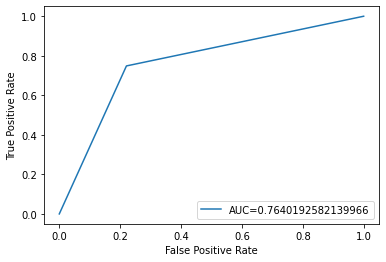

In [35]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(test_output,  prediction_test)
auc = metrics.roc_auc_score(test_output,  prediction_test)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

# CLASSIFICATION REPORT KNN

In [36]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(test_output, Y_pred_knn))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72     23209
           1       0.72      0.74      0.73     23206

    accuracy                           0.73     46415
   macro avg       0.73      0.73      0.73     46415
weighted avg       0.73      0.73      0.73     46415



Text(42.0, 0.5, 'Truth')

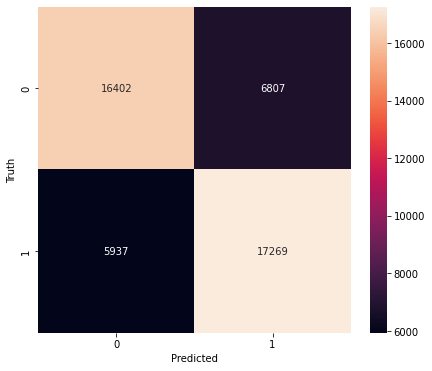

In [37]:
import seaborn as sns

cm = tf.math.confusion_matrix(labels=test_output, predictions=Y_pred_knn)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

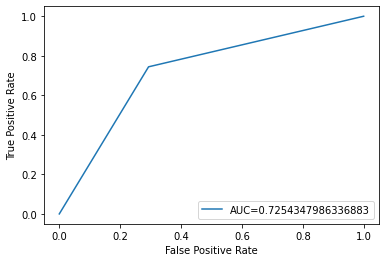

In [38]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(test_output,  Y_pred_knn)
auc = metrics.roc_auc_score(test_output,  Y_pred_knn)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [40]:
TP = 21548
TN = 17373
FP = 5833
FN = 5120
accuracy = (TP+TN)/(TP+TN+FP+FN)
sensitivity = TP / (TP + FN)
specificity = TN / (FP + TN)
precision = TP / (TP + FP)
NPV = TN / (TN + FN)
FDR = FP / (FP + TP)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
F1 = TP*2 / ((TP*2) + FP + FN)
print('Accuracy: {:.4f}'.format(accuracy))
print('sensitivity: {:.4f}'.format(sensitivity))
print('specificity: {:.4f}'.format(specificity))
print('precision: {:.4f}'.format(precision))
print('NPV: {:.4f}'.format(NPV))
print('FPR: {:.4f}'.format(FPR))
print('FDR: {:.4f}'.format(FDR))
print('FNR: {:.4f}'.format(FNR))
print('F1: {:.4f}'.format(F1))

Accuracy: 0.7804
sensitivity: 0.8080
specificity: 0.7486
precision: 0.7870
NPV: 0.7724
FPR: 0.2514
FDR: 0.2130
FNR: 0.1920
F1: 0.7974
